# 0. About

This notebook is to test out the construction of the pipeline, and to see if we chain everything correctly.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn import set_config
import pandas as pd
import seaborn as sns
from sklearn.datasets import make_regression

rs_num = 42
set_config(display="diagram")

In [2]:
X, y = make_regression(
    n_samples=400, n_features=15, n_informative=3, 
    effective_rank=1, tail_strength=0.2, 
    n_targets=1, random_state=rs_num
)

[X_train, X_test, y_train, y_test] = train_test_split(X, y, random_state=rs_num)

# 1. Manually Put Everything Together

We can apply the following transformations:
1. Standardization
2. PCA with scree plot threshold, which requires a customized Transformer

For the estimator, we can use the Gaussian Process regression.

In [3]:
class MyGPR(GaussianProcessRegressor):
    def __init__(
        self, 
        kernel=None, 
        *, 
        alpha=1e-10, 
        optimizer="fmin_l_bfgs_b", 
        n_restarts_optimizer=0, 
        normalize_y=False, 
        copy_X_train=True, 
        random_state=None, 
        **kwargs
    ):
        super().__init__(
            kernel=kernel, 
            alpha=alpha, 
            optimizer=optimizer, 
            n_restarts_optimizer=n_restarts_optimizer, 
            normalize_y=normalize_y, 
            copy_X_train=copy_X_train, 
            random_state=random_state, 
            **kwargs
        )
        
    def fit(self, X, y):
        self.set_params(kernel=ConstantKernel(constant_value=1)*RBF(length_scale=np.ones((X.shape[1], ))))
        super().fit(X, y)
        return self

In [4]:
# standardization
manual_scaler = StandardScaler().fit(X_train)
X_train_scaled = manual_scaler.transform(X_train)

# PCA
manual_tpca = PCA(n_components=0.95).fit(X_train_scaled)
X_train_scaled_pca = manual_tpca.transform(X_train_scaled)

# GPR
manual_kernel = ConstantKernel(constant_value=1)*RBF(length_scale=np.ones((manual_tpca.n_components_, )))
manual_gpr = GaussianProcessRegressor(
    kernel=manual_kernel, n_restarts_optimizer=9, random_state=rs_num
)
manual_gpr.fit(X_train_scaled_pca, y_train)

GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=[1, 1, 1, 1, 1, 1, 1]),
                         n_restarts_optimizer=9, random_state=42)

Now with everything ready, we can apply GPR repeated 5-fold cross-validation.

In [5]:
manual_cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=rs_num)
manual_gpr_scores = cross_validate(
    manual_gpr, X_train_scaled_pca, y_train, cv=manual_cv
)

# 2. Chain Everything Together with Pipeline

In [6]:
gpr_pipeline = Pipeline(
    [('scaler', StandardScaler()), 
     ('pca', PCA(n_components=0.95, random_state=rs_num)), 
     ('gpr', 
      MyGPR(
          kernel=ConstantKernel(constant_value=1)*RBF(length_scale=np.ones((10, ))), 
          n_restarts_optimizer=9, random_state=rs_num)
     )]
)
gpr_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('pca', PCA(n_components=0.95, random_state=42)),
                ('gpr',
                 MyGPR(kernel=1**2 * RBF(length_scale=[1, 1, 1, 1, 1, 1, 1]),
                       n_restarts_optimizer=9, random_state=42))])

Now do the 5-fold cross-validation.

In [7]:
pipeline_cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=rs_num)
pipeline_scores = cross_validate(gpr_pipeline, X_train, y_train, cv=pipeline_cv)

# 3. Compare Two Results

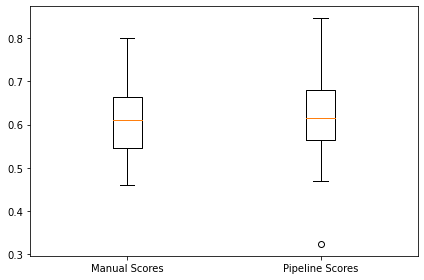

In [8]:
fig, ax = plt.subplots()

ax.boxplot(
    [manual_gpr_scores['test_score'], pipeline_scores['test_score']], 
    labels=['Manual Scores', 'Pipeline Scores']
)

plt.tight_layout()